In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

---
## About the data

Dataset Overview:
- The dataset comprises 541,909 entries organized into 8 columns: InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country

Quantity:

- Average quantity per transaction: 9.55.
- Quantity ranges from -80995 to 80995, indicating returns.
- Data spread suggests outliers.

UnitPrice:

- Average unit price: $4.61.
- Unit prices range from -$11062.06 to $38970.
- Spread implies outliers.

CustomerID:

- 406,829 entries, some missing.
- IDs range from 12346 to 18287, identifying customers.

InvoiceNo:

- 25,900 unique invoices.
- Most frequent: 573585 (1114 times).

StockCode:

- 4,070 unique codes.
- Top code: 85123A (2313 times).

Description:

- 4,223 unique descriptions.
- Top: "WHITE HANGING HEART T-LIGHT HOLDER" (2369 times).
- Some missing descriptions.

Country:

- Transactions from 38 countries.
- Majority (91.4%) from the UK.

In [59]:
df = pd.read_csv('data.csv', encoding="ISO-8859-1")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [61]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [62]:
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


---
## 1. Data cleaning
- Address missing values
- Remove duplicates
- Filter out cancelled transactions
- Correct stockcode errors
- Clean up descriptions
- Fix zero unit prices
- Manage outliers


### 1.1. Handling Missing Values

- CustomerID (24.93% missing values):
    - Nearly a quarter of the CustomerID column is missing, essential for clustering and recommendations.
    - To maintain cluster integrity and analysis accuracy, removing rows with missing CustomerIDs is preferred.

- Description (0.27% missing values):
    - Despite a minor missing percentage, inconsistencies suggest potential errors.
    - Given the low missing rate, removing rows with missing Descriptions is prudent to avoid error propagation.

Removing rows with missing CustomerID and Description ensures a cleaner dataset for accurate clustering and recommendation system construction.

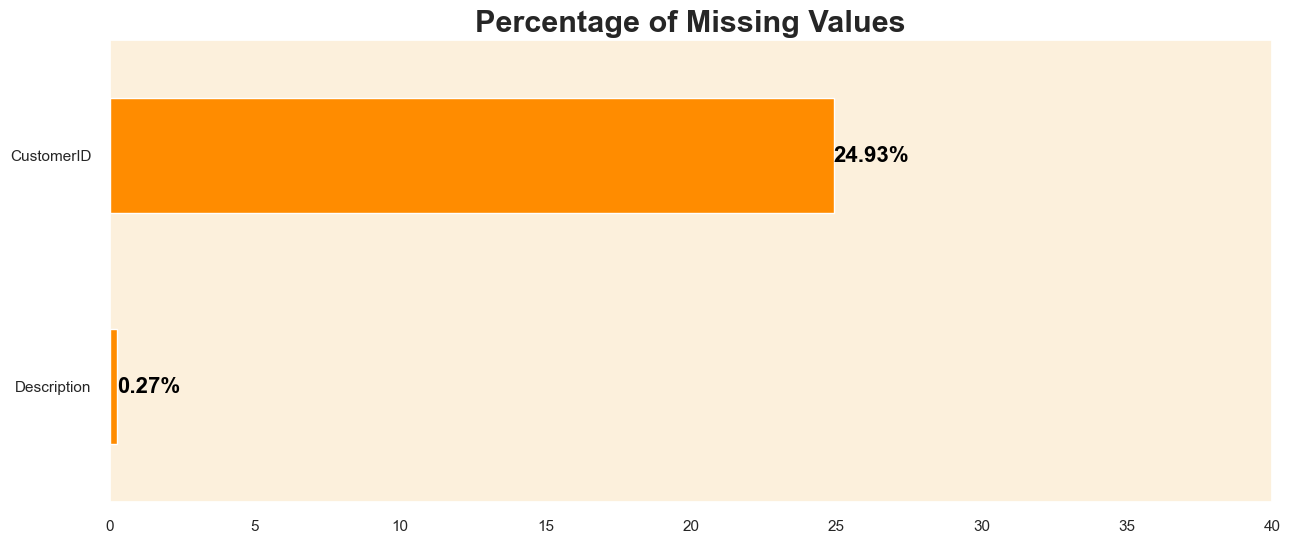

In [64]:
missing_data = df.isnull().mean() * 100
missing_data_sorted = missing_data[missing_data > 0].sort_values()

plt.figure(figsize=(15, 6))
missing_data_sorted.plot(kind='barh')

# Annotate the values
for index, value in enumerate(missing_data_sorted):
    plt.text(value, index, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=16, color='black')

plt.xlim(0, 40)
plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.grid(axis='both', color='none')
plt.show()

In [11]:
df = df.dropna(subset=['CustomerID', 'Description'])
df.isnull().sum().sum()

0

### 1.2. Remove Duplicates

Removing completely identical rows, likely stemming from data recording errors, from the dataset. This will lead to a cleaner dataset, aiding in more precise customer clustering and product recommendations.

In [12]:
duplicate_rows = df[df.duplicated(keep=False)]
duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])

duplicate_rows_sorted.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom


In [13]:
num_duplicates = df.duplicated().sum()
print(f"The dataset contains {num_duplicates} duplicate rows that need to be removed.")

# Removing duplicate rows and updating the dataframe
df.drop_duplicates(inplace=True)

# Displaying the new number of rows in the dataframe
num_rows_after_removal = df.shape[0]
print(f"After removing duplicates, the dataset contains {num_rows_after_removal} rows.")


The dataset contains 5225 duplicate rows that need to be removed.
After removing duplicates, the dataset contains 401604 rows.


### 1.3. Handling Cancelled transactions

- Understanding Cancelled Transactions:
    - Identification: Cancelled transactions start with "C" in InvoiceNo, with negative quantities.
    - Variety of Products: UnitPrice shows a wide range, indicating cancellations across various product values.

- Importance:
    - Enhanced Clustering: Incorporating cancellation data enriches customer behavior insights.
    - Improved Recommendations: Identifying high cancellation rate products refines recommendations.

In [14]:
# Filter out the rows with InvoiceNo starting with "C" and create a new column indicating the transaction status
df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

# Analyze the characteristics of these rows (considering the new column)
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancelled_transactions.describe().drop('CustomerID', axis=1)

,Quantity,UnitPrice
count,8872.000000,8872.000000
mean,-30.774910,18.899512
std,1172.249902,445.190864
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,4.950000
max,-1.000000,38970.000000


In [15]:
# Finding the percentage of cancelled transactions
cancelled_percentage = (cancelled_transactions.shape[0] / df.shape[0]) * 100

# Printing the percentage of cancelled transactions
print(f"The percentage of cancelled transactions in the dataset is: {cancelled_percentage:.2f}%")

The percentage of cancelled transactions in the dataset is: 2.21%


### 1.4. Correcting StockCode Anomalies

- Majority of stock codes (3,676 out of 3,684) adhere to the standard 5-digit format.
- Anomalies, like "BANK CHARGES" and "POST," deviate from this format.
- Anomalies comprise only 0.48% of records.
- To prioritize clustering based on product purchases and recommendation system development, excluding these anomalies ensures accurate analysis.



In [16]:
unique_stock_codes = df['StockCode'].nunique()
print(f"The number of unique stock codes in the dataset is: {unique_stock_codes}")

The number of unique stock codes in the dataset is: 3684


In [17]:
# Finding the number of numeric characters in each unique stock code
unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

# Printing the value counts for unique stock codes
print("Value counts of numeric character frequencies in unique stock codes:")
print("-"*70)
print(numeric_char_counts_in_unique_codes)


Value counts of numeric character frequencies in unique stock codes:
----------------------------------------------------------------------
5    3676
0       7
1       1
dtype: int64


In [18]:
# Finding the top 10 most frequent stock codes
top_10_stock_codes = df['StockCode'].value_counts(normalize=True).head(10) * 100
top_10_stock_codes

85123A    0.514188
22423     0.471609
85099B    0.413093
47566     0.350843
84879     0.349847
20725     0.335156
22720     0.304778
POST      0.297806
22197     0.276392
23203     0.275894
Name: StockCode, dtype: float64

**Stock Code Anomalies**: Notably, anomalies like 'POST' exist among the stock codes. Addressing these anomalies is vital to maintain the project's focus on product-based clustering and recommendation systems, ensuring data integrity.

In [19]:
unique_stock_codes = df['StockCode'].unique()
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

print("Anomalous stock codes:")
print("-"*22)
for code in anomalous_stock_codes:
    print(code)

Anomalous stock codes:
----------------------
POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


In [20]:
percentage_anomalous = (df['StockCode'].isin(anomalous_stock_codes).sum() / len(df)) * 100
print(f"Percentage of records with anomalous stock codes: {percentage_anomalous:.2f}%")

Percentage of records with anomalous stock codes: 0.48%


In [21]:
df = df[~df['StockCode'].isin(anomalous_stock_codes)]
df.shape

(399689, 9)

### 1.5. Cleaning Description Column

#### Descriptions:
- Top descriptions are household items, mainly kitchenware and decorative items.
- All descriptions are in uppercase, possibly a standardized format.

#### Strategy:
- **Step 1:** Remove rows with non-product descriptions: ["Next Day Carriage", "High Resolution Image"]
- **Step 2:** Standardize remaining descriptions to uppercase.


In [22]:
# Find unique descriptions containing lowercase characters
lowercase_descriptions = [desc for desc in df['Description'].unique() if any(char.islower() for char in desc)]

print("Unique descriptions containing lowercase characters:")
print("-" * 50)
for desc in lowercase_descriptions:
    print(desc)

Unique descriptions containing lowercase characters:
--------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


In [23]:
# Service-related descriptions
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]

# Calculate percentage of records with service-related descriptions
service_related_percentage = (df['Description'].isin(service_related_descriptions).sum() / len(df)) * 100

print(f"Percentage of records with service-related descriptions: {service_related_percentage:.2f}%")

Percentage of records with service-related descriptions: 0.02%


In [24]:
df = df[~df['Description'].isin(service_related_descriptions)]

# Standardize descriptions to uppercase
df['Description'] = df['Description'].str.upper()
df.shape[0]

399606

### 1.6. Treating Zero Unit Prices

- 33 transactions have zero unit prices.
- Quantity ranges from 1 to 12,540, with significant variability.
- Including these transactions may introduce noise.
- Removing them ensures a cleaner dataset, vital for accurate analysis.


In [25]:
df[df['UnitPrice']==0].describe()[['Quantity']]

,Quantity
count,33.000000
mean,420.515152
std,2176.713608
min,1.000000
25%,2.000000
50%,11.000000
75%,36.000000
max,12540.000000


In [26]:
# Remove zero price transactions
df = df[df['UnitPrice'] != 0]

### Note: Treating Outliner

In K-means clustering, outliers and data scale affect centroid positions and cluster assignments. For this customer behavior project, outlier treatment is deferred until after feature engineering to retain valuable transactional data.

In [27]:
df.reset_index(drop=True, inplace=True)
df.shape

(399573, 9)

---
## 2. Feature engineering

- RFM
- Product diversity
- Behavior Features
- Geographic Features
- Cancellation
- Seasonality and Trends



### 2.1. Apply RFM method

RFM (Recency, Frequency, Monetary) is a method for analyzing customer value and segmentation:**

- Recency (R): How recently a customer purchased. Lower values suggest higher engagement.
- Frequency (F): How often a customer purchases. Higher values indicate loyalty.
- Monetary (M): Total amount spent. Higher values mean greater contribution.

These metrics inform personalized marketing and recommendations.



#### **Recency(R)**: 
Introducing "Days Since Last Purchase" to gauge customer recency. Low values suggest recent activity, indicating high engagement.

In [28]:
# Convert InvoiceDate to datetime type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Extract date from InvoiceDate
df['InvoiceDay'] = df['InvoiceDate'].dt.date

# Find most recent purchase date for each customer
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# Find most recent date in entire dataset
most_recent_date = df['InvoiceDay'].max()

# Convert to datetime before subtraction
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate days since last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Drop InvoiceDay column
customer_data.drop(columns=['InvoiceDay'], inplace=True)

In [29]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


#### **Frequency(F)**: 
Creating two features to measure customer engagement:
- Total Transactions: Reflects the overall number of transactions made by each customer.
- Total Products Purchased: Indicates the cumulative quantity of products purchased by each customer.

In [30]:
# Calculate total transactions per customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index().rename(columns={'InvoiceNo': 'Total_Transactions'})

# Calculate total products purchased per customer
total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index().rename(columns={'Quantity': 'Total_Products_Purchased'})

# Merge
customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

customer_data.head()


,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,12346.0,325,2,0
1,12347.0,2,7,2458
2,12348.0,75,4,2332
3,12349.0,18,1,630
4,12350.0,310,1,196


#### **Monetary(M)**: 
Creating 2 features:

- Total Spend: The sum of UnitPrice multiplied by Quantity for all transactions
- Average Transaction Value: Total Spend divided by Total Transactions


In [31]:
# Calculate the total spend by each customer
df['Total_Spend'] = df['UnitPrice'] * df['Quantity']
total_spend = df.groupby('CustomerID')['Total_Spend'].sum().reset_index()

# Calculate the average transaction value for each customer
average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12346.0,325,2,0,0.00,0.000000
1,12347.0,2,7,2458,4310.00,615.714286
2,12348.0,75,4,2332,1437.24,359.310000
3,12349.0,18,1,630,1457.55,1457.550000
4,12350.0,310,1,196,294.40,294.400000


### 2.2. Product Diversity
Explore customer product purchase diversity to inform personalized strategies; "Unique Products Purchased" indicates the number of distinct products bought by a customer, aiding in segmentation and personalized recommendations.

In [32]:
# Calculate number of unique products purchased per customer
unique_products_purchased = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# Merge feature into customer_data
customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')

# Display first few rows
customer_data.head()


,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,12346.0,325,2,0,0.00,0.000000,1
1,12347.0,2,7,2458,4310.00,615.714286,103
2,12348.0,75,4,2332,1437.24,359.310000,21
3,12349.0,18,1,630,1457.55,1457.550000,72
4,12350.0,310,1,196,294.40,294.400000,16


### 2.3. Behavior Features
- Average Days Between Purchases: Represents customers' average wait time before their next purchase, aiding future predictions
- Favorite Shopping Day: Identifies the peak shopping day of the week, optimizing promotions
- Favorite Shopping Hour: Refers to the peak shopping hour of the day, aligning marketing campaigns effectively

In [33]:
# Extract day of week and hour from InvoiceDate
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# Calculate average days between consecutive purchases
average_days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days)).groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# Find favorite shopping day of the week
favorite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

# Find favorite shopping hour of the day
favorite_shopping_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

# Merge features into customer_data
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16


### 2.4. Geographic Features
- Introduce the "Country" feature, crucial for understanding region-specific buying patterns and optimizing logistics for an online retailer. 
- Given 89% of transactions from the UK, a binary UK transactions feature can streamline clustering, especially for algorithms like K-means.

In [34]:
df['Country'].value_counts(normalize=True).head()

United Kingdom    0.890971
Germany           0.022722
France            0.020402
EIRE              0.018440
Spain             0.006162
Name: Country, dtype: float64

In [35]:
# Group by CustomerID and Country to get number of transactions per country for each customer
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

# Get the country with the maximum transactions for each customer
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')

# Create binary column for UK customers
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

# Merge with customer_data
customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')

customer_data.head()


,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0


### 2.5. Cancellation insights
- Cancellation Frequency: Total canceled transactions per customer, identifying patterns and informing reduction strategies.
- Cancellation Rate: Proportion of canceled transactions out of total, offering insights into dissatisfaction and guiding targeted strategies.

In [36]:
# Calculate total transactions per customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# Calculate cancelled transactions
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

# Merge cancellation frequency data
customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')

# Replace NaN values with 0
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

# Calculate Cancellation Rate
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']

# Display first few rows
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0


### 2.6. Seasonality and Trends
Introduce trends' features:
- Monthly_Spending_Mean: Average monthly spending per customer.
- Monthly_Spending_Std: Variability in monthly spending.
- Spending_Trend: Trend in spending over time.

In [37]:
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

# Calculate monthly spending for each customer
monthly_spending = df.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

# Calculate Seasonal Buying Patterns
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Replace NaN values in Monthly_Spending_Std with 0
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

# Calculate Spending Trends
def calculate_trend(spend_data):
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    else:
        return 0

# Apply the calculate_trend function
spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

# Merge features into the customer_data dataframe
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')

customer_data.head()


,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5,0.000000,0.000000,0.000000
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0,359.310000,203.875689,-100.884000
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0,1457.550000,0.000000,0.000000
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0,294.400000,0.000000,0.000000


---
### New customer_data Ready for Modeling

In [38]:
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)
customer_data = customer_data.convert_dtypes()
customer_data.head(10)

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0
5,12352.0,36,8,463,1265.41,158.17625,57,3.13253,1,14,0,1,0.125,316.3525,134.700629,9.351
6,12353.0,204,1,20,89.0,89.0,4,0.0,3,17,0,0,0.0,89.0,0.0,0.0
7,12354.0,232,1,530,1079.4,1079.4,58,0.0,3,13,0,0,0.0,1079.4,0.0,0.0
8,12355.0,214,1,240,459.4,459.4,13,0.0,0,13,0,0,0.0,459.4,0.0,0.0
9,12356.0,22,3,1573,2487.43,829.143333,52,5.315789,1,9,0,0,0.0,829.143333,991.462585,-944.635


---
## 3. Detect and handle outliners

- Using the Isolation Forest algorithm, we identified and handled outliers in our dataset.

- Key Points:
    - Detection: Outliers were marked in a new column, Is_Outlier.
    - Scores: Anomaly scores were calculated for each record.

- Insights: About 5% of customers were flagged as outliers, a reasonable proportion.

- Strategy:
    - Separate outliers for analysis and optionally save them.
    - Remove outliers from the main dataset.
    - Drop auxiliary columns (Outlier_Scores and Is_Outlier).

In [39]:
model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on the dataset
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# Creating a column to identify outliers (1 for inliers, -1 for outliers)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,1,0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,1,0
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,1,0
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,1,0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,1,0


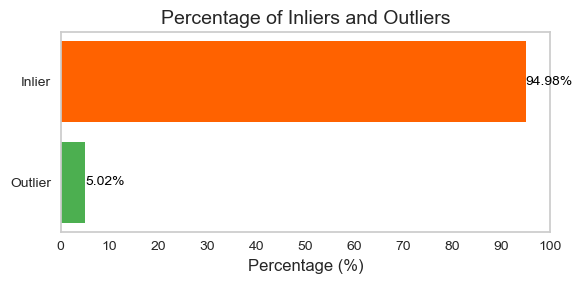

In [40]:
# Calculating the percentage of inliers and outliers
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

# Plotting the percentage of inliers and outliers
plt.figure(figsize=(6, 3))
colors = ['#ff6200', '#4CAF50']
plt.barh(outlier_percentage.index.map({0: 'Inlier', 1: 'Outlier'}), outlier_percentage, color=colors)

# Adding percentage labels on the bars
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', va='center', fontsize=10, color='black')

plt.title('Percentage of Inliers and Outliers', fontsize=14)
plt.xlabel('Percentage (%)', fontsize=12)
plt.gca().invert_yaxis()
plt.xticks(ticks=np.arange(0, 110, 10), fontsize=10)
plt.grid(axis='both', color='none')
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [41]:
# Separate the outliers for analysis and remove them from the main dataset
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0].drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
customer_data_cleaned.reset_index(drop=True, inplace=True)

customer_data_cleaned.shape

(4067, 16)

---
## 4. Feature Scaling

Scaling features is vital for clustering and dimensionality reduction. In K-means, varied scales can distort results, while PCA may misrepresent patterns without uniform scaling.

In [42]:
# Exclude unnecessary columns from scaling
columns_to_exclude = ['CustomerID', 'Is_UK', 'Day_Of_Week']
columns_to_scale = [col for col in customer_data_cleaned.columns if col not in columns_to_exclude]

# Scale the features
scaler = StandardScaler()
customer_data_scaled = customer_data_cleaned.copy()
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_cleaned[columns_to_scale])

# Display the first few rows of the scaled dataset
customer_data_scaled.head()


,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,2.345802,-0.477589,-0.754491,-0.813464,-1.317106,-0.908471,-0.310564,1,-1.086929,1,0.420541,0.417623,-1.329018,-0.713318,0.090868
1,12347.0,-0.905575,0.707930,2.005048,2.366920,1.528132,0.815119,-0.128438,1,0.647126,0,-0.545753,-0.432111,0.989511,1.259961,0.116774
2,12348.0,-0.170744,-0.003381,1.863591,0.247087,0.343279,-0.570512,0.672476,3,2.814696,0,-0.545753,-0.432111,0.023997,0.466213,-0.491708
3,12349.0,-0.744516,-0.714692,-0.047205,0.262074,5.418285,0.291283,-0.310564,0,-1.520443,0,-0.545753,-0.432111,4.159521,-0.713318,0.090868
4,12350.0,2.194809,-0.714692,-0.534446,-0.596223,0.043327,-0.655002,-0.310564,2,1.514154,0,-0.545753,-0.432111,-0.220428,-0.713318,0.090868


---
## 5. Correlation

- Before KMeans clustering, evaluating multicollinearity among features is vital. High correlations may obscure patterns, resulting in less meaningful clusters. Techniques like PCA can alleviate multicollinearity by transforming correlated features into uncorrelated ones, preserving variance and enhancing clustering quality.

- The heatmap reveals several pairs of variables with high correlations, suggesting multicollinearity. These include **Monthly_Spending_Mean and Average_Transaction_Value, Total_Spend and Total_Products_Purchased, Total_Transactions and Total_Spend, Cancellation_Rate and Cancellation_Frequency, and Total_Transactions and Total_Products_Purchased.**

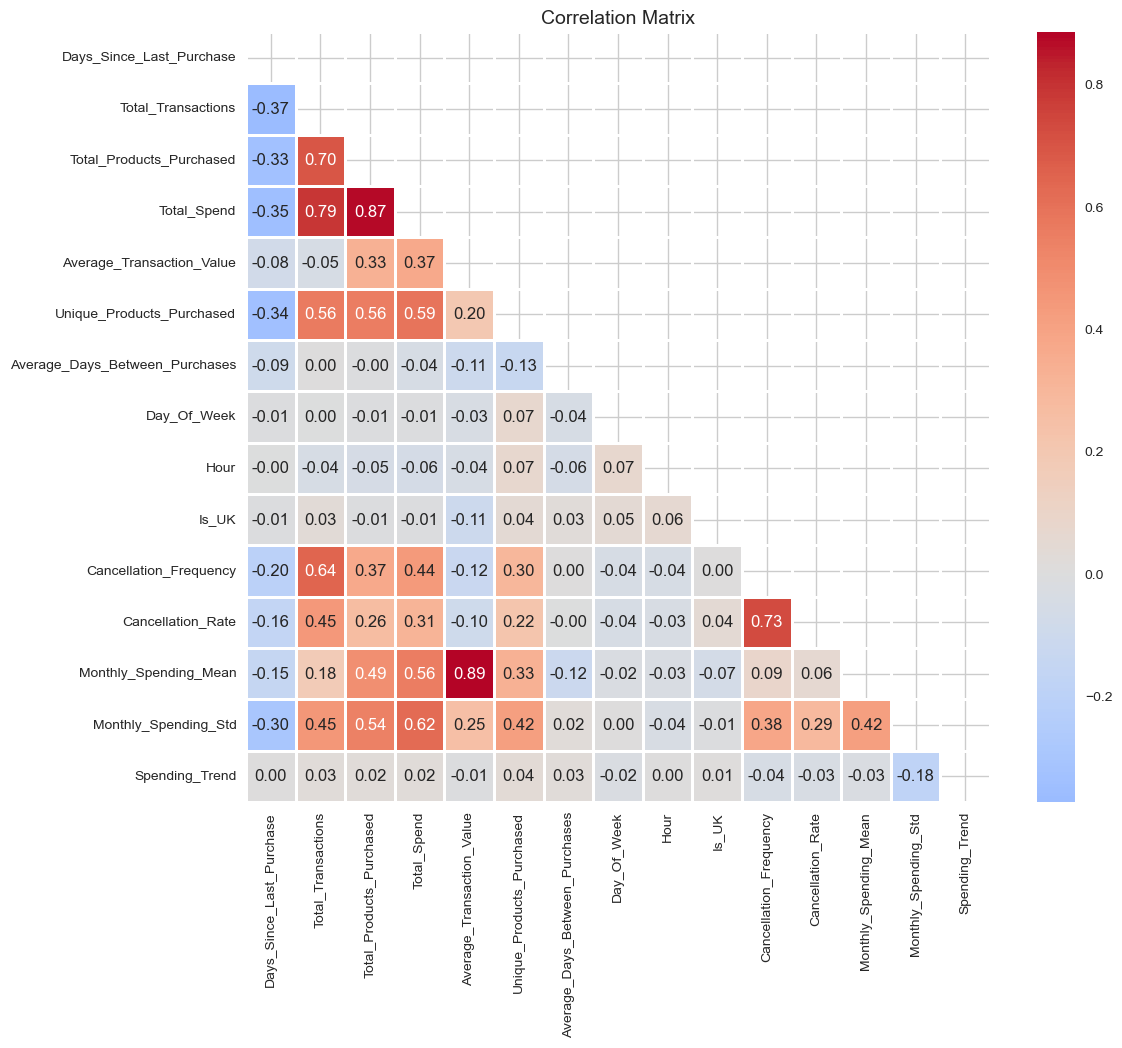

In [43]:
# Reset background style
sns.set_style('whitegrid')

# Calculate the correlation matrix excluding the 'CustomerID' column
corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()

# Create a mask to only show the lower triangle of the matrix
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()


---
## 6. Dimensionality Reduction

- PCA reduces dataset dimensionality while preserving essential features by transforming variables into orthogonal principal components.
- How to apply PCA:
    - Apply PCA to all dataset components.
    - Optimal point: With 6 components capturing 81% of variance, balancing preservation and reduction.



In [44]:
# Setting CustomerID as the index column
customer_data_scaled.set_index('CustomerID', inplace=True)

# Apply PCA
pca = PCA().fit(customer_data_scaled)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Set the optimal k value (based on our analysis, we can choose 6)
optimal_k = 6

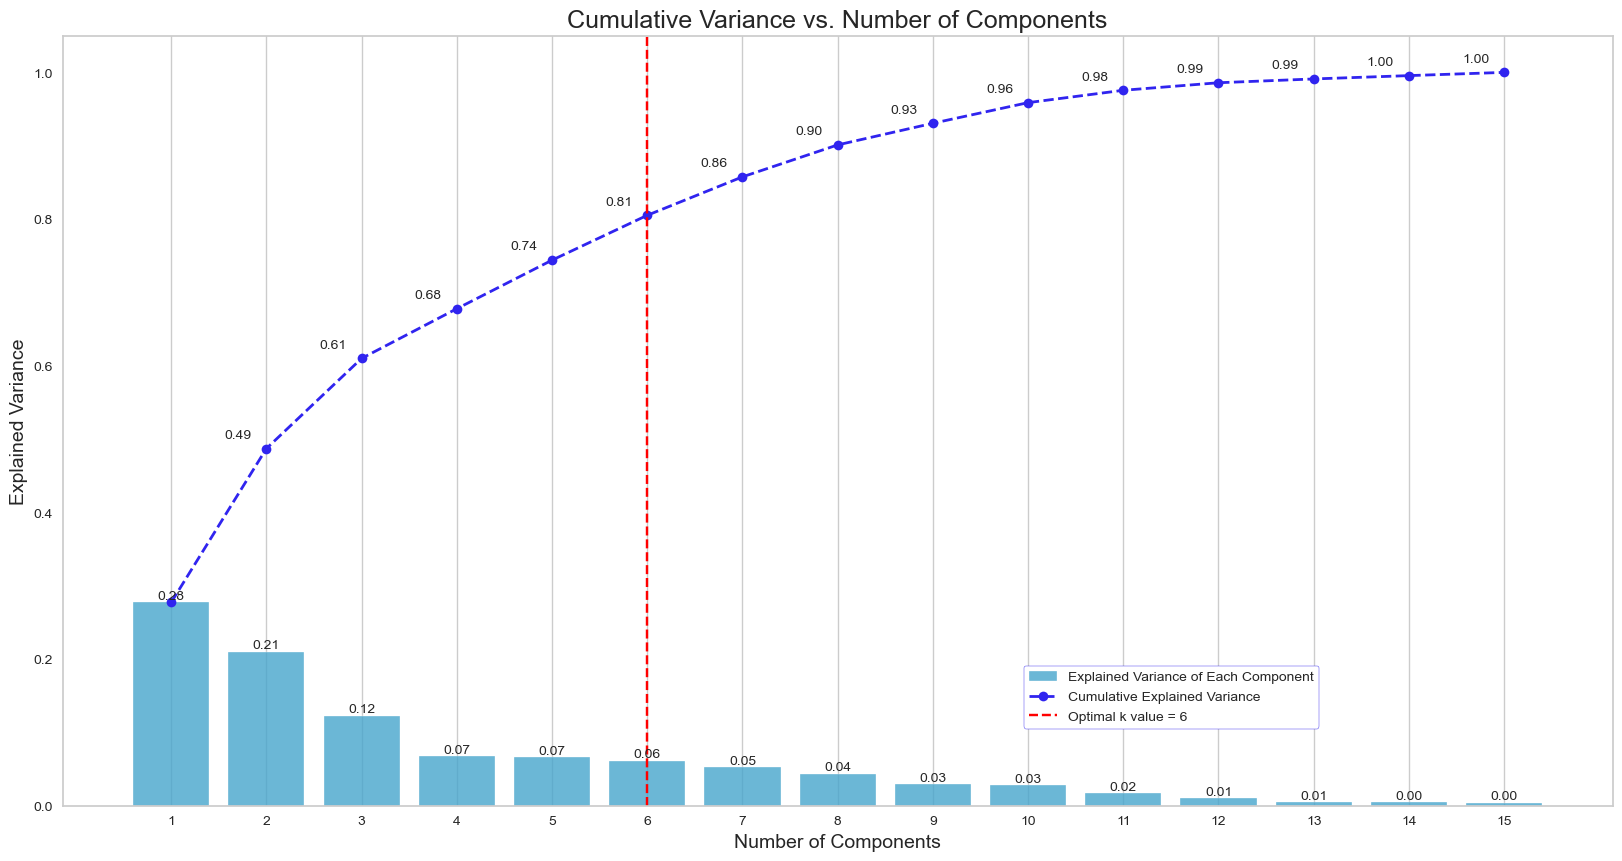

In [45]:
# Define custom colors
bar_color = '#2FAFE3'
line_color = '#3024EF'
optimal_k_color = 'red'

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color=bar_color,
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color=line_color, linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color=optimal_k_color, linestyle='--', label=f'Optimal k value = {optimal_k}') 

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,  
           edgecolor=line_color)  

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()


The plot illustrates variance explained by each principal component and cumulative variance.

Key insights:

- First component explains 28% of variance.
- First two components together: 49%.
- Optimal point: After 6 components, capturing about 81% of total variance. Retaining these components balances significant variance preservation and dimensionality reduction.

In [46]:
pca = PCA(n_components=6)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_scaled)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_scaled.index

customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
12346.0,-2.186469,-1.705370,-1.576745,1.008187,-0.411803,-1.658012
12347.0,3.290264,-1.387375,1.923310,-0.930990,-0.010591,0.873150
12348.0,0.584684,0.585019,0.664727,-0.655411,-0.470280,2.306657
12349.0,1.791116,-2.695652,5.850040,0.853418,0.677111,-1.520098
12350.0,-1.997139,-0.542639,0.578781,0.183682,-1.484838,0.062672


Extract the coefficients for each principal component:

In [47]:
# Define a function to highlight the top 3 absolute values in each column of a dataframe
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #EEA0A0' if i in top3 else '' for i in column.index]

# Create the PCA component DataFrame and apply the highlighting function
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],  
                     index=customer_data_scaled.columns)

pc_df.style.apply(highlight_top3, axis=0)


,PC1,PC2,PC3,PC4,PC5,PC6
Days_Since_Last_Purchase,-0.217859,-0.013986,0.067660,0.273430,-0.240968,-0.373059
Total_Transactions,0.380301,0.014759,-0.259180,-0.138165,-0.017356,-0.028257
Total_Products_Purchased,0.401425,0.007365,0.069133,-0.134806,0.057476,-0.013373
Total_Spend,0.431260,0.010159,0.065165,-0.092047,0.025202,-0.036947
Average_Transaction_Value,0.176225,-0.015544,0.589050,0.114307,0.021847,-0.101738
Unique_Products_Purchased,0.324992,0.063346,0.014010,-0.230502,-0.193981,0.124604
Average_Days_Between_Purchases,-0.022600,-0.036007,-0.127341,-0.160627,0.753462,0.211787
Day_Of_Week,-0.026572,0.994650,-0.006591,0.028870,0.058359,-0.060799
Hour,-0.024259,0.056388,-0.002019,-0.226832,-0.528881,0.621915
Is_UK,-0.001014,0.007435,-0.018378,-0.013419,-0.005353,0.014384


---
## 7. KMeans Clustering



#### 7.1.  Find the opimal number of k clusters, using: Elbow Method, Sihouette Method


#### Elbow Method:

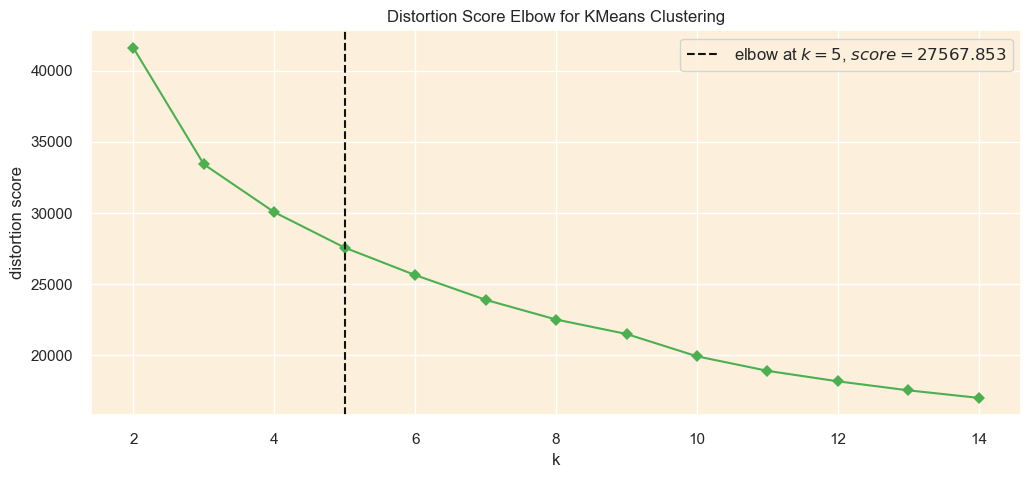

In [48]:
# Set plot style, background color, and color palette
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})
sns.set_palette(['#4CAF50'])

# Instantiate and visualize the KElbowVisualizer
plt.figure(figsize=(12, 5))
visualizer = KElbowVisualizer(KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0), k=(2, 15), timings=False)
visualizer.fit(customer_data_pca)
visualizer.show();


The Elbow method using YellowBrick suggests k=5 as optimal. However, the absence of a distinct elbow point is common in real-world data. indicating the optimal k may range from 3 to 7. Refinement using silhouette analysis and business insights will help determine a practical k value.

#### Sihouette Method:

In [49]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))
             

    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):    
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

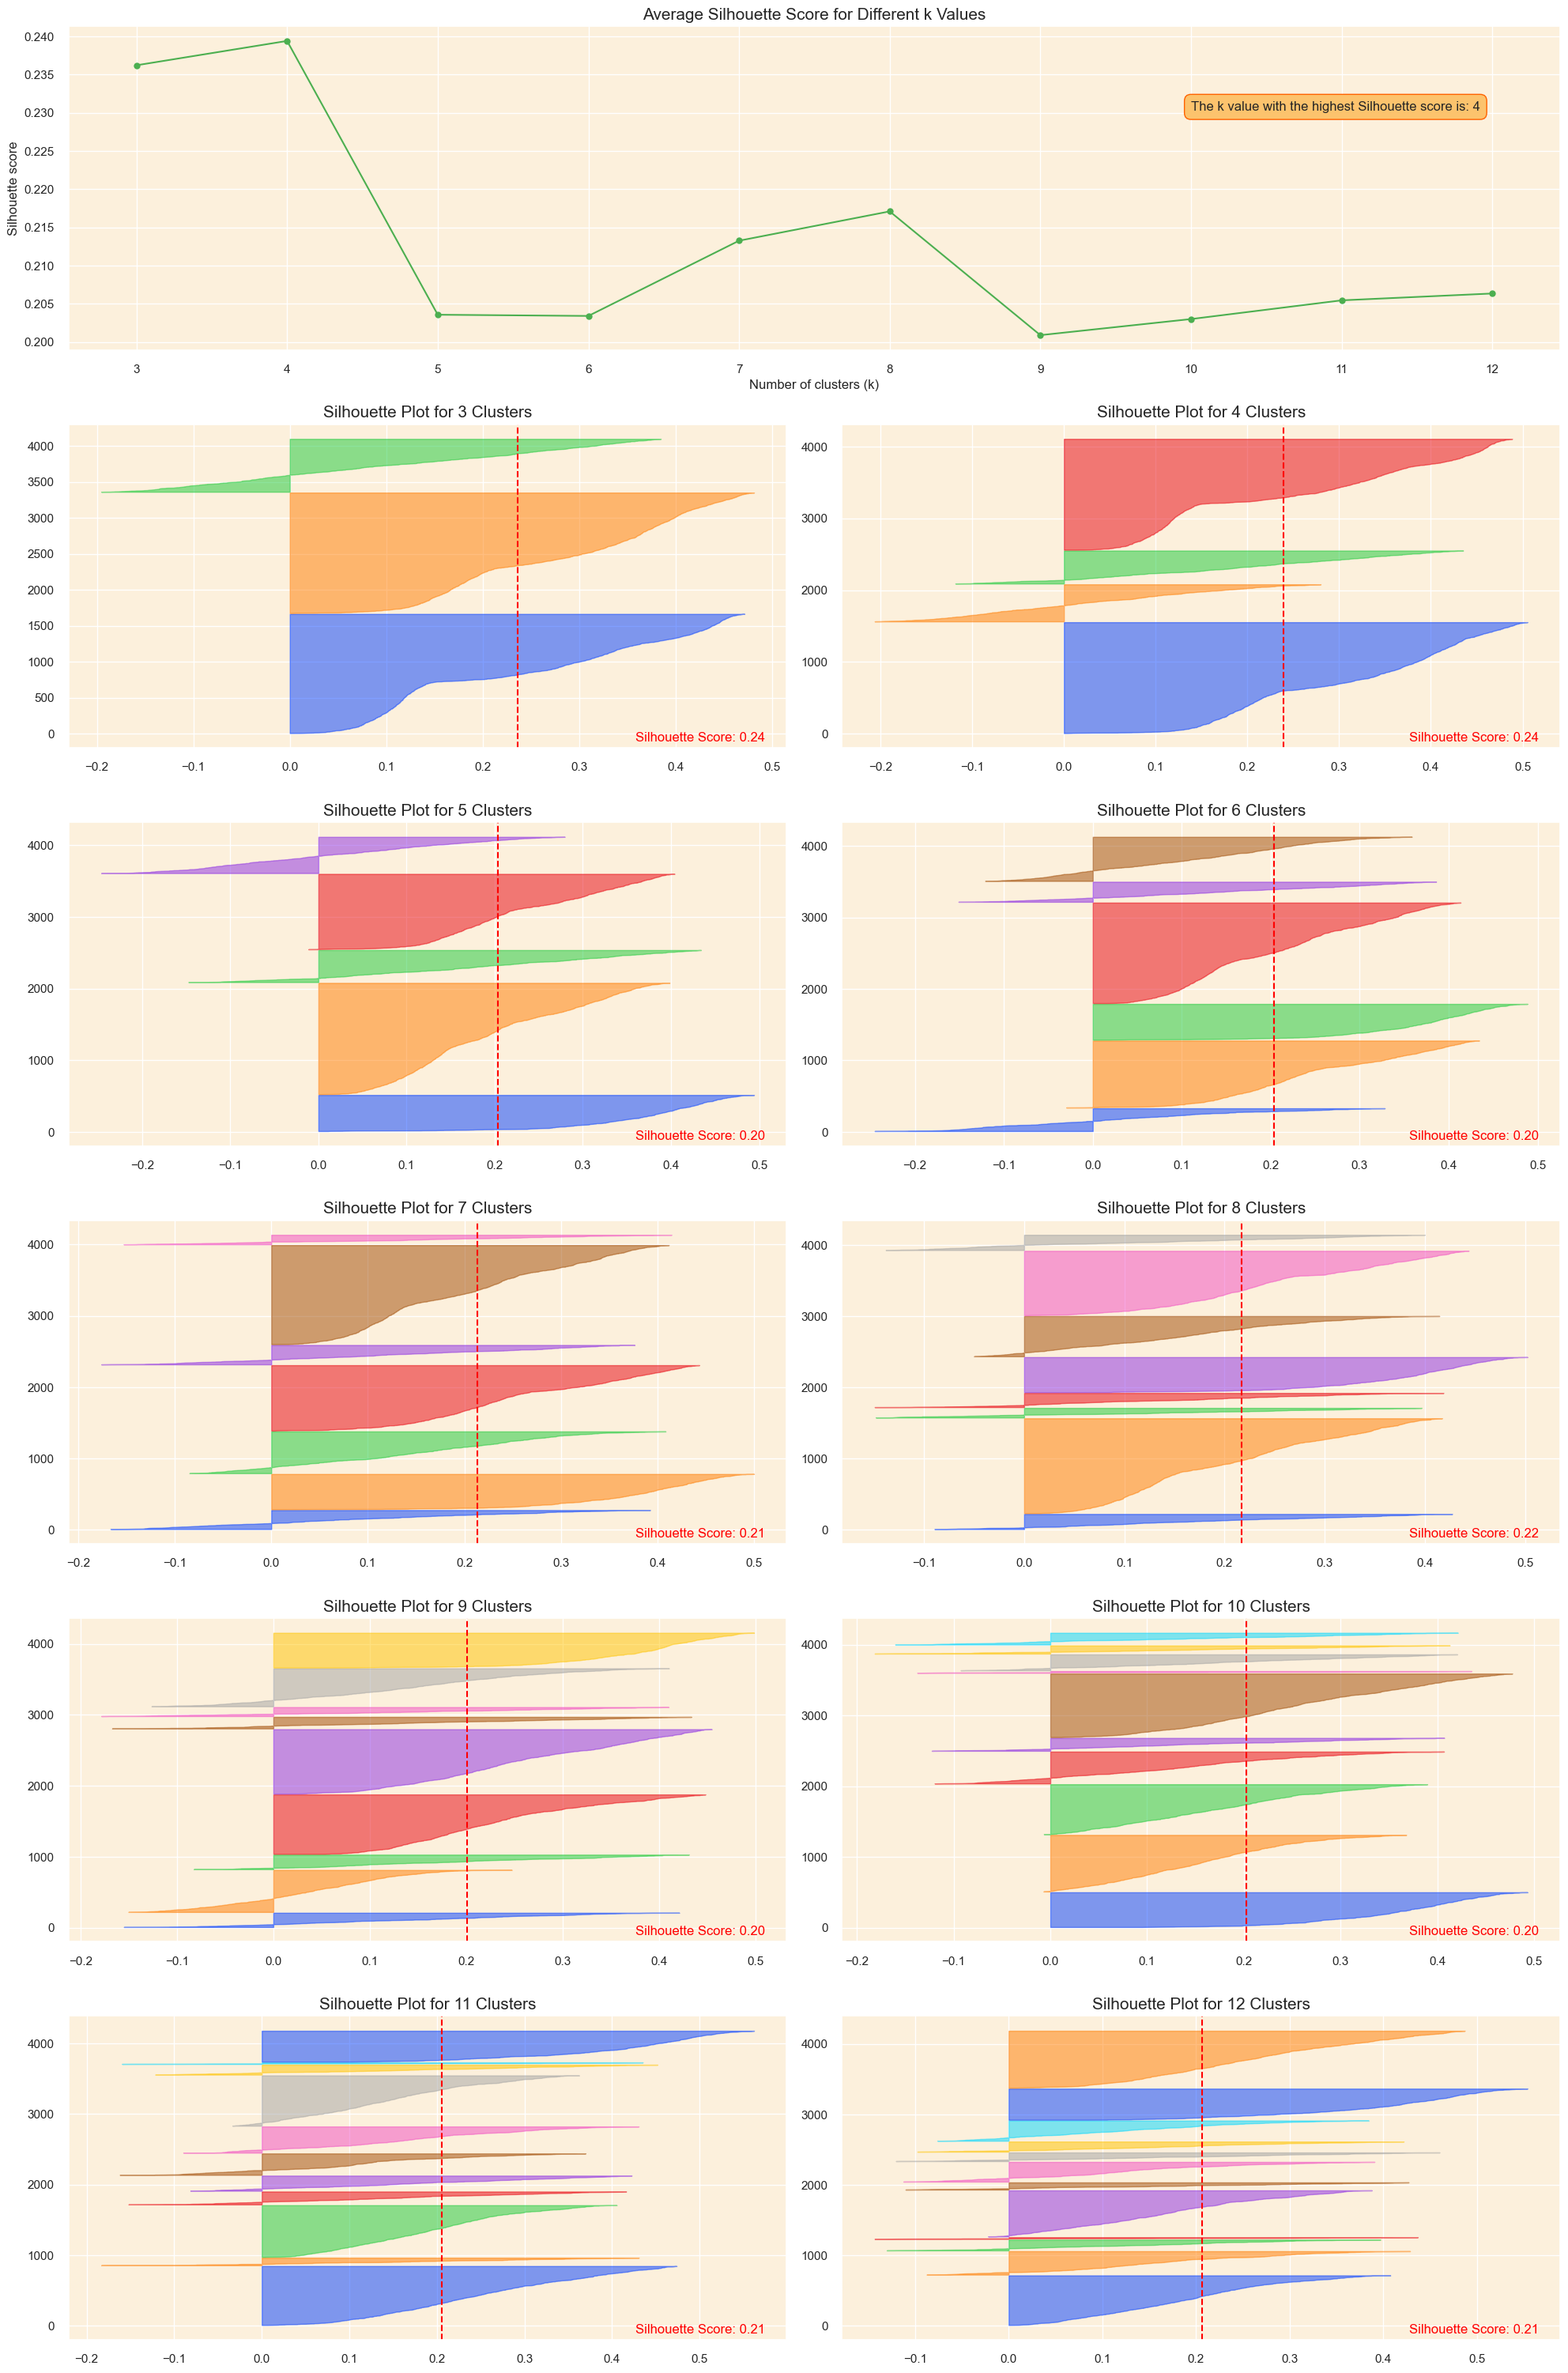

In [50]:
silhouette_analysis(customer_data_pca, 3, 12, figsize=(20, 50))

Based on the silhouette plots, selecting k=3 is optimal. This decision yields more balanced and well-defined clusters, enhancing the reliability of our clustering solution.

#### 7.2 Apply Kmeans

Apply K-means clustering to segment customers based on their purchasing behaviors and traits, using the optimal k=3

In [51]:
# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0).fit(customer_data_pca)

# Get cluster frequencies
cluster_frequencies = Counter(kmeans.labels_)

# Create label mapping based on frequency
label_mapping = {label: new_label for new_label, (label, _) in enumerate(cluster_frequencies.most_common())}

# Reverse the mapping based on criteria
label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

# Map new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Assign new cluster labels
customer_data_cleaned['cluster'] = new_labels
customer_data_pca['cluster'] = new_labels

customer_data_cleaned.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,cluster
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,2
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,0
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,1
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,2
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,2


---
## 8. KMeans Evaluation



In [52]:
colors = ['#e8000b', '#1ac938', '#023eff']

# Create separate data frames for each cluster
cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]

# Create a 3D scatter plot
fig = go.Figure()

# Add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'], 
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'], 
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'], 
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))

# Set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

# Show the plot
fig.show()

In [53]:
# Compute number of customers
num_observations = len(customer_data_pca)

# Separate the features and the cluster labels
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+---------------------+
|         Metric          |        Value        |
+-------------------------+---------------------+
| Number of Observations  |        4067         |
|    Silhouette Score     | 0.23622848017098882 |
| Calinski Harabasz Score |  1257.174776654063  |
|  Davies Bouldin Score   | 1.3682695376074656  |
+-------------------------+---------------------+



**Evaluation metrics:**

- Silhouette Score: ~0.236 indicates fair cluster separation, with some overlap.
- Calinski Harabasz Score: 1257.17 suggests well-defined clusters.
- Davies Bouldin Score: 1.37 shows moderate cluster similarity.

Overall, metrics indicate good cluster quality, with room for optimization using alternative techniques.

---
## 9. Cluster analysis and Profiling
Analyze each cluster's characteristics to discern unique behaviors and preferences among customer segments


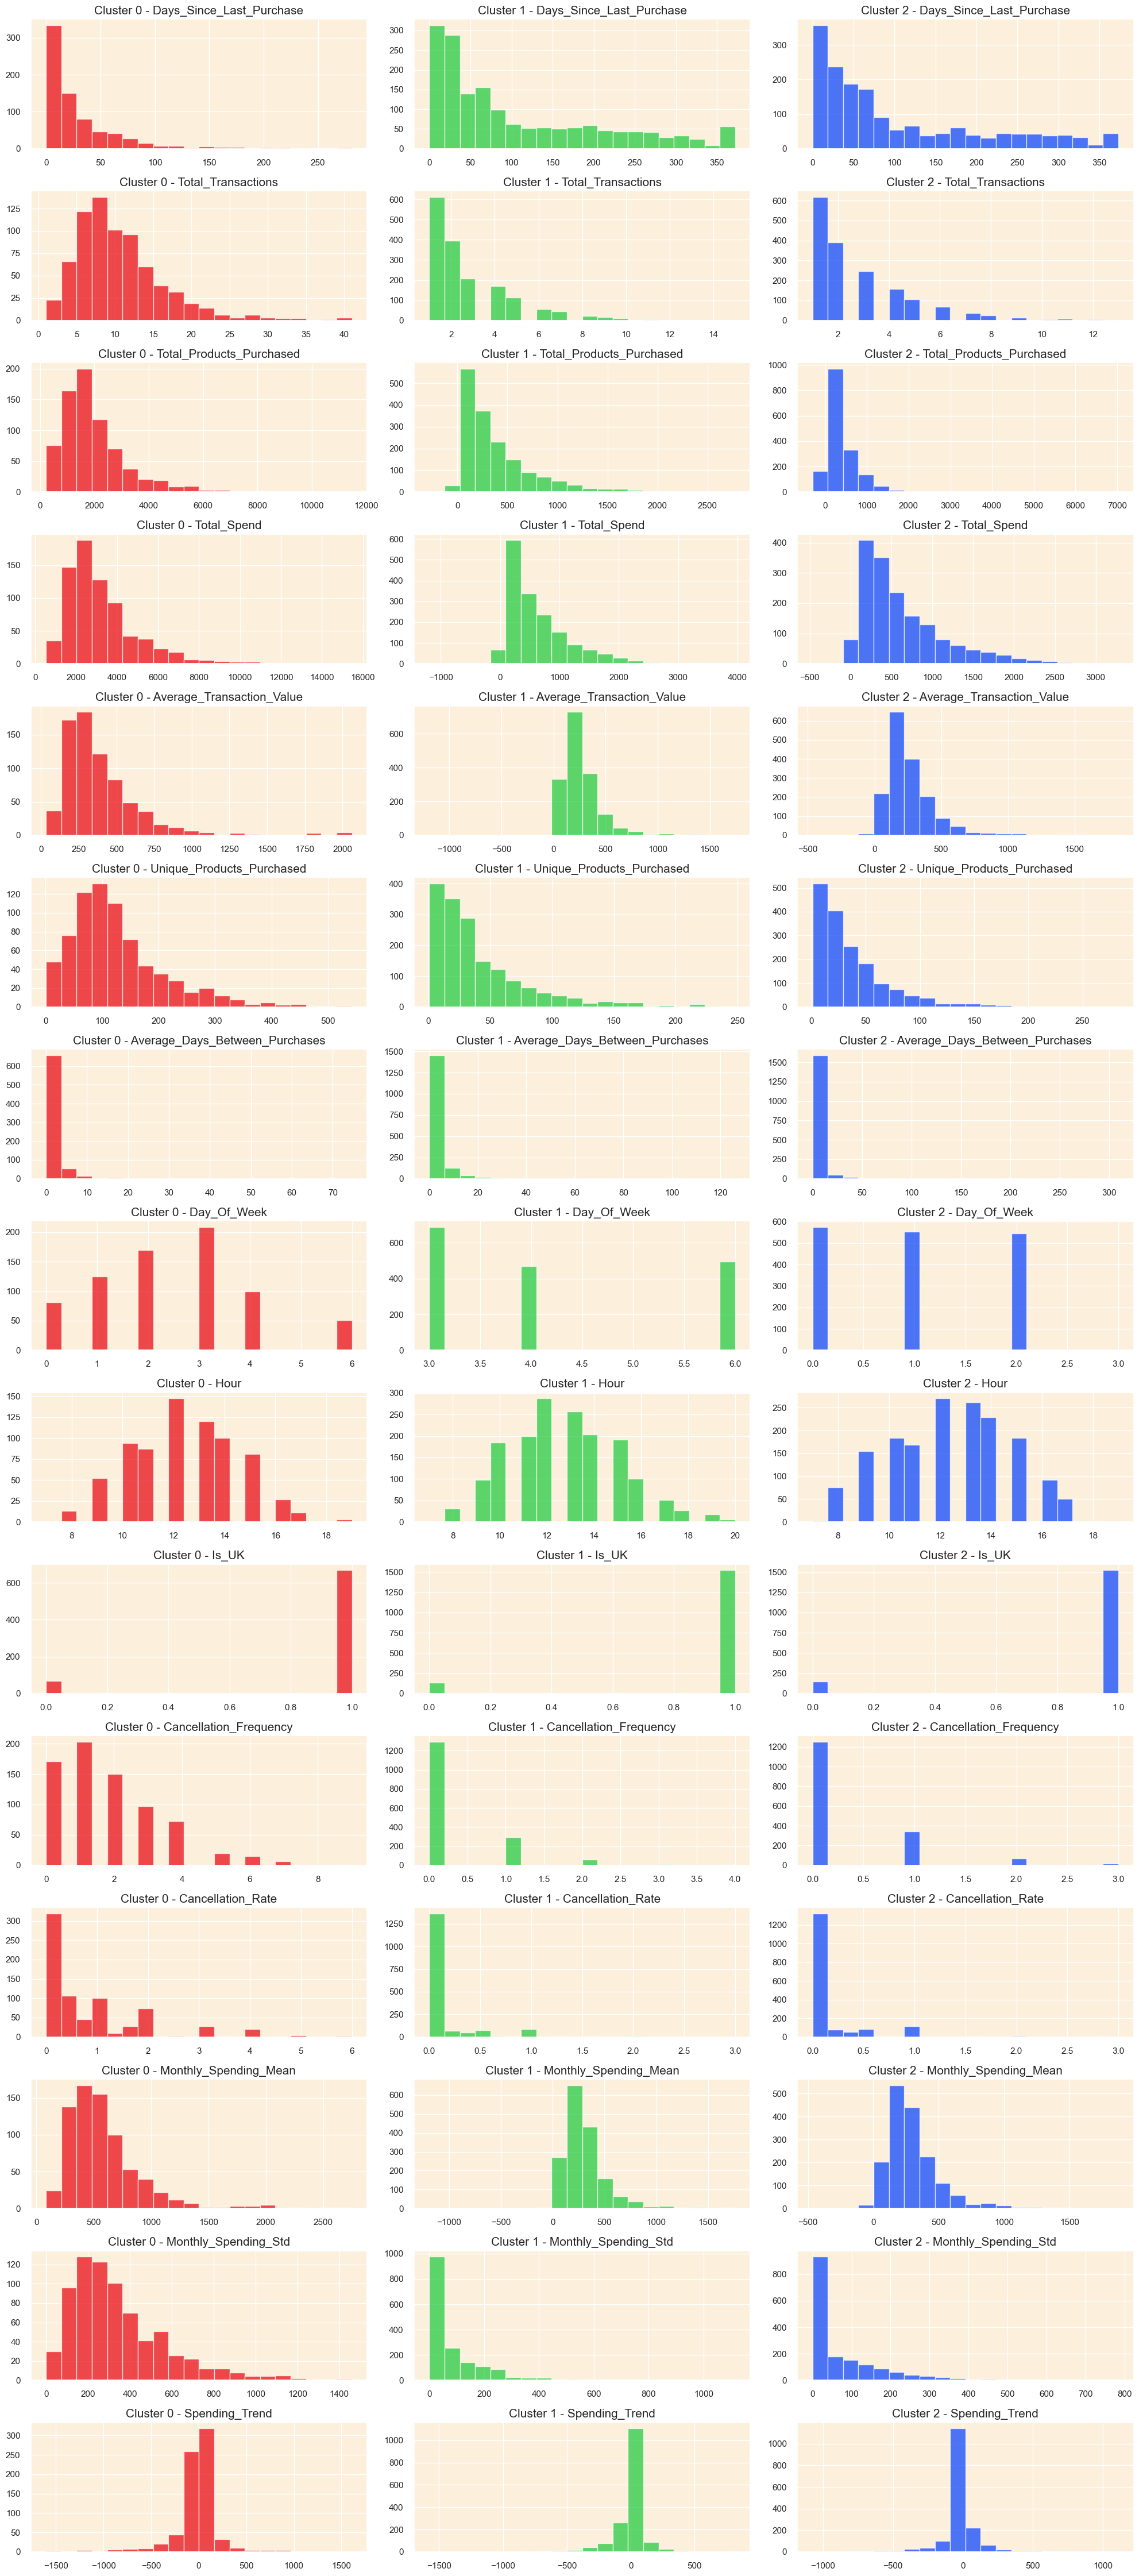

In [54]:
# Plot histograms for each feature segmented by the clusters
features = customer_data_cleaned.columns[1:-1]
clusters = customer_data_cleaned['cluster'].unique()
clusters.sort()

# Setting up the subplots
n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))

# Plotting histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_data_cleaned.loc[customer_data_cleaned['cluster'] == cluster, feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

fig.tight_layout()
plt.show()


**Cluster 0 - Casual Weekend Shoppers:**
- Less frequent shopping with lower spending.
- Stable monthly spending, prefer weekends, and fewer product purchases.

**Cluster 1 - Occasional Big Spenders:**
- Shop infrequently but make large purchases.
- Increasing spending pattern, mainly UK based, shop post-work hours, and higher transaction cancellations.

**Cluster 2 - Eager Early-Bird Shoppers:**
- High spenders with varied purchases.
- Shop early, high spending variability, and a recent downtrend in spending.

---
## 10. Recomendation

The goal is to create a recommendation engine suggesting three top products not yet purchased by a customer but popular within their cluster, catering to the primary 95% of customers. For the 5% outliers, random product recommendations will engage them.



Steps:
- Use Clusters: Segment customers into groups with similar shopping habits.
- Identify Favorites: Find the most purchased items within each group.
- Tailor Recommendations: Suggest popular items a customer hasn't bought.
- Handle Outliers: Offer random products to atypical customers.


In [55]:
# Step 1: Extract the CustomerIDs of the outliers and remove their transactions from the main dataframe
outlier_customer_ids = outliers_data['CustomerID'].astype('float').unique()
df_filtered = df[~df['CustomerID'].isin(outlier_customer_ids)]

# Step 2: Ensure consistent data type for CustomerID across both dataframes before merging
customer_data_cleaned['CustomerID'] = customer_data_cleaned['CustomerID'].astype('float')

# Step 3: Merge the transaction data with the customer data to get the cluster information for each transaction
merged_data = df_filtered.merge(customer_data_cleaned[['CustomerID', 'cluster']], on='CustomerID', how='inner')

# Step 4: Identify the top 10 best-selling products in each cluster based on the total quantity sold
best_selling_products = merged_data.groupby(['cluster', 'StockCode', 'Description'])['Quantity'].sum().reset_index()
best_selling_products = best_selling_products.sort_values(by=['cluster', 'Quantity'], ascending=[True, False])
top_products_per_cluster = best_selling_products.groupby('cluster').head(10)

# Step 5: Create a record of products purchased by each customer in each cluster
customer_purchases = merged_data.groupby(['CustomerID', 'cluster', 'StockCode'])['Quantity'].sum().reset_index()

# Step 6: Generate recommendations for each customer in each cluster
recommendations = []
for cluster in top_products_per_cluster['cluster'].unique():
    top_products = top_products_per_cluster[top_products_per_cluster['cluster'] == cluster]
    customers_in_cluster = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster]['CustomerID']
    
    for customer in customers_in_cluster:
        # Identify products already purchased by the customer
        customer_purchased_products = customer_purchases[(customer_purchases['CustomerID'] == customer) & 
                                                         (customer_purchases['cluster'] == cluster)]['StockCode'].tolist()
        
        # Find top 3 products in the best-selling list that the customer hasn't purchased yet
        top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
        top_3_products_not_purchased = top_products_not_purchased.head(3)
        
        # Append the recommendations to the list
        recommendations.append([customer, cluster] + top_3_products_not_purchased[['StockCode', 'Description']].values.flatten().tolist())

# Step 7: Create a dataframe from the recommendations list and merge it with the original customer data
recommendations_df = pd.DataFrame(recommendations, columns=['CustomerID', 'cluster', 'Rec1_StockCode', 'Rec1_Description', \
                                                 'Rec2_StockCode', 'Rec2_Description', 'Rec3_StockCode', 'Rec3_Description'])
customer_data_with_recommendations = customer_data_cleaned.merge(recommendations_df, on=['CustomerID', 'cluster'], how='right')

In [56]:
customer_data_with_recommendations.set_index('CustomerID').iloc[:, -6:].sample(10, random_state=0)

,Rec1_StockCode,Rec1_Description,Rec2_StockCode,Rec2_Description,Rec3_StockCode,Rec3_Description
CustomerID,,,,,,
13243.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
13232.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
14997.0,18007,ESSENTIAL BALM 3.5G TIN IN ENVELOPE,84879,ASSORTED COLOUR BIRD ORNAMENT,17003,BROCADE RING PURSE
14948.0,18007,ESSENTIAL BALM 3.5G TIN IN ENVELOPE,84879,ASSORTED COLOUR BIRD ORNAMENT,17003,BROCADE RING PURSE
12596.0,18007,ESSENTIAL BALM 3.5G TIN IN ENVELOPE,84879,ASSORTED COLOUR BIRD ORNAMENT,17003,BROCADE RING PURSE
16686.0,22616,PACK OF 12 LONDON TISSUES,85099B,JUMBO BAG RED RETROSPOT,84879,ASSORTED COLOUR BIRD ORNAMENT
17101.0,18007,ESSENTIAL BALM 3.5G TIN IN ENVELOPE,84879,ASSORTED COLOUR BIRD ORNAMENT,17003,BROCADE RING PURSE
14954.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
18123.0,18007,ESSENTIAL BALM 3.5G TIN IN ENVELOPE,84879,ASSORTED COLOUR BIRD ORNAMENT,17003,BROCADE RING PURSE
